In [99]:
from trace import Trace
import pandas as pd
import os
from executor import Executor
from conf import LisaLogging
LisaLogging.setup()
import json
from env import TestEnv
from trappy.stats.Topology import Topology
from bart.sched.SchedMultiAssert import SchedMultiAssert
from bart.sched.SchedAssert import SchedAssert
import json
from trappy.plotter import plot_trace

%matplotlib inline
%load_ext autoreload
%autoreload 2

2017-03-16 14:00:03,644 INFO    : root         : Using LISA logging configuration:
2017-03-16 14:00:03,645 INFO    : root         :   /home/brejac01/sources/lisa/logging.conf


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
results_dir = '/home/brejac01/sources/lisa/results/20170316_102548'

In [36]:
platform = TestEnv.load_platform(results_dir)
# fix hikey
if platform['topology'] == [[0, 1, 2, 3, 4, 5, 6, 7]]:
    platform['topology'] = [[0, 1, 2, 3], [4, 5, 6, 7]]
topology = Topology(clusters = platform['topology'])

In [3]:
experiments = Executor.find_experiments(results_dir)

2017-03-16 11:43:44,418 WARNING : Executor     : Reconstructing Experiment.wload not yet supported, will be None
2017-03-16 11:43:44,419 WARNING : Executor     : Reconstructing Experiment.conf not yet supported, will be None


In [11]:
traces = [Trace(platform, e.out_dir, ['cpu_frequency', 'cpu_idle', 'sched_switch']) for e in experiments]

2017-03-16 12:23:03,105 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2017-03-16 12:23:03,849 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2017-03-16 12:23:04,593 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2017-03-16 12:23:05,153 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2017-03-16 12:23:05,629 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2017-03-16 12:23:06,452 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2017-03-16 12:23:07,305 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2017-03-16 12:23:08,159 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2017-03-16 12:23:09,029 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2017-03-16 12:23:09,910 INFO    : Trace        : Platform clusters verified to be Frequency

In [23]:
def get_freq(trace):
    freqs = trace.data_frame.trace_event('cpu_frequency')['frequency']
    [freq] = freqs.drop_duplicates().tolist()
    return freq

In [91]:
def get_packed(experiment, trace):
    if experiment.wload:
        tasks = experiment.wload.tasks.keys()
    else:
        tasks = [c for c in trace.getTasks().keys() if 'task_' in c]

    ma = SchedMultiAssert(trace.ftrace, topology, tasks)    
    
#     start = min(t['starttime'] for t in ma.getStartTime().values())
#     end = max(t['endtime'] for t in ma.getEndTime().values())
#     print end - start
    cluster_conclusions = []
    for cluster in topology.get_level('cluster'):
        residencies = [t['residency'] for p, t in ma.getResidency('cluster', cluster, percent=True).iteritems()]
        if all(r > 90 for r in residencies):
            cluster_conclusions.append('PACKED')
        else:
            cluster_conclusions.append(None)
    clusters_packed = [i for i, c in enumerate(cluster_conclusions) if c == 'PACKED']
    
    if not clusters_packed:
        # print "I don't think we packed onto any cluster"
        return 'Packed'
        # plot_trace(trace.ftrace)
    elif len(clusters_packed) == 1:
        [i] = clusters_packed
        # print 'I think we packed onto cluster {} ({})'.format(i, te.topology.get_node('cluster', i))
        return 'Unpacked'
    else:
        raise Exception('this code is borken')

In [97]:
def get_energy(experiment):
    with open(os.path.join(experiment.out_dir, 'samples.csv')) as f:
        print len(f.readlines())
    with open(os.path.join(experiment.out_dir, 'energy.json')) as f:
        return sum(json.load(f).values())


In [98]:
results = []
for experiment, trace in zip(experiments, traces):
    freq = get_freq(trace)
    # packed = get_packed(experiment, trace)
    energy = get_energy(experiment)
    # results.append((freq, packed, energy))

82603
82603
82262
82262
80897
66561
65878
65195
64513
64854
55297
55297
54614
54955
54273
58710
58710
58369
59393
59393
128342
128001
126977
126294
127659
66219
65878
65537
66219
66219
59051
59734
59051
59051
58710
55297
55638
55297
54955
55297
82262
83286
82262
82603
82262
127659
128342
126977
128342
128001


In [107]:
found_freqs = set()
for trace in traces[:0]:
    freq = get_freq(trace)
    if freq in found_freqs:
        continue
    found_freqs.add(freq)
    print freq
    plot_trace(trace.ftrace)

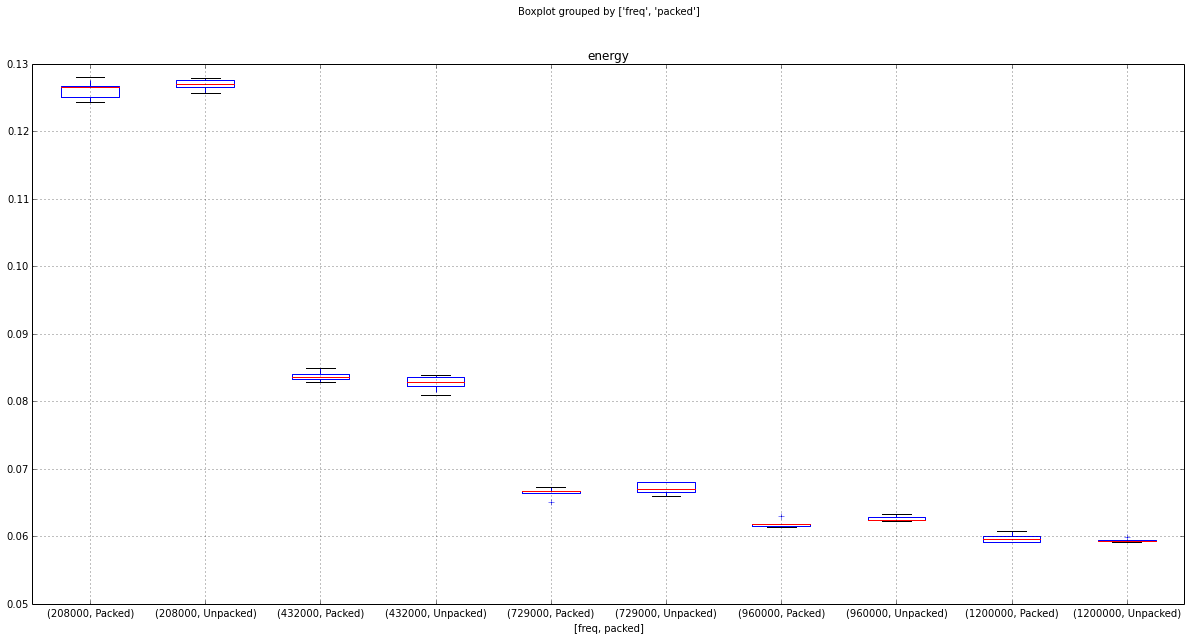

In [78]:
df = pd.DataFrame(results, columns=['freq', 'packed', 'energy'])
df = df
df.boxplot(by=['freq', 'packed'], figsize=(20, 10))